In [2]:
import sys
import argparse
import numpy as np
import scipy.signal as sp
import processing as pr
import matplotlib.pyplot as plt
import pandas as pd
from ruamel.yaml import YAML as ym
import datetime

%matplotlib widget
import mplcursors

sys.path.append("../preprocessing")
from generate_chirp import generate_chirp

# Widgets are only needed if you want to use the interactive plot at the end
# Installation instructions: https://ipywidgets.readthedocs.io/en/latest/user_install.html
import ipywidgets as widgets

import scipy.fft

In [3]:
from matplotlib import font_manager

font_manager.fontManager.addfont("/home/thomas/Documents/StanfordGrad/Source_Sans_Pro/SourceSansPro-Regular.ttf")

font_manager.findfont("Source Sans Pro")

'/home/thomas/Documents/StanfordGrad/Source_Sans_Pro/SourceSansPro-Regular.ttf'

In [331]:
# 2021-11-24 Roble Pre-Test
# prefix = "../../drone/radar_data/20211124-roble/20211124_173951"
# px4_logs = None

# 2021-11-24 Flight 1
# prefix = "../../drone/radar_data/20211124-lag/20211124_185351"
# px4_logs = "../../px4_logs/2021-11-24/18_45_08/18_45_08_"
# telemetry_time_offset_s = 55

# 2021-11-24 Flight 2
# prefix = "../../drone/radar_data/20211124-lag/20211124_192115"
# px4_logs = "../../px4_logs/2021-11-24/19_14_06/19_14_06_"
# telmetry_time_offset_s = 34

# 2021-12-01 Roble Pretest
# prefix = "../../drone/radar_data/20211201-roble-pretest/20211201_184957"
# px4_logs = None

# 2021-12-01 Lag Flight
# prefix = "../../drone/radar_data/20211201-lag/20211201_200316"
# px4_logs = "../../px4_logs/2021-12-01/19_57_33/19_57_33_"
# telemetry_time_offset_s = 20

# 2021-12-06 Roble
# prefix = "../../drone/radar_data/20211206-roble/20211206_183918" # Moving test 1
# px4_logs = None

#prefix = "../../drone/radar_data/20211206-roble/20211206_192749"
#px4_logs = None

# 2021-12-08 Lake Lag Flight
# prefix = "../../drone/radar_data/20211208-lag/20211208_193107"
# px4_logs = "../../px4_logs/2021-12-08/19_17_22/19_17_22_"
# telemetry_time_offset_s = 175


# prefix = "../../drone/radar_data/20220308-aeromao-field/20220307_153106" # 2nd flight on 3/8 w/ Aeromao

# Svalbard Day 2

#prefix = "../../drone/radar_data/20220319-tellbreen/20220319_070117" # original spot, just before separating wings
#prefix = "../../drone/radar_data/20220319-tellbreen/20220319_074151" # high power, wings separated
#prefix = "../../drone/radar_data/20220319-tellbreen/20220319_081044" # moved to location 2 - near Anna - wings still separated
#prefix = "../../drone/radar_data/20220319-tellbreen/20220319_083328" # rectangular window, settings used for 1st walk
#prefix = "../../drone/radar_data/20220319-tellbreen/20220319_082104"

# Svalbard Day 3

#prefix = "../../drone/radar_data/20220320-tellbreen/20220320_063039" # spot 1 with Anna's antennas
#prefix = "../../drone/radar_data/20220320-tellbreen/20220320_070536" # first one with UAV antennas
#prefix = "../../drone/radar_data/20220320-tellbreen/20220320_071226" # nice clear reflection at 68 meters
prefix = "../../drone/radar_data/20220320-tellbreen/20220320_074049"

px4_logs = None



yaml_file = prefix + "_config.yaml"
bin_file = prefix + "_rx_samps.bin"


n_stack = 1 # Do additional stacking in this notebook - set > 1 to enable
zero_sample_idx = 159 # The index of the 0 distance sample -- will change with platforms and config changes -- if unsure, just set to 0

In [332]:
# Initialize Constants
yaml = ym()
with open(yaml_file) as stream:
    config = yaml.load(stream)
    sample_rate = config["PLOT"]["sample_rate"]    # Hertz
    sig_speed = config["PLOT"]["sig_speed"] / np.sqrt(3.17)

    #expected_n_rxs = int(config['CHIRP']['num_pulses'] / config['CHIRP']['num_presums'])
    
    rx_len_samples = int(config['CHIRP']['rx_duration'] * config['GENERATE']['sample_rate'])
    
rx_samps = bin_file

--- Loaded constants from config.yaml ---
--- Building Chirp ---
len(tx_sig): 44800
0:00:00.125041


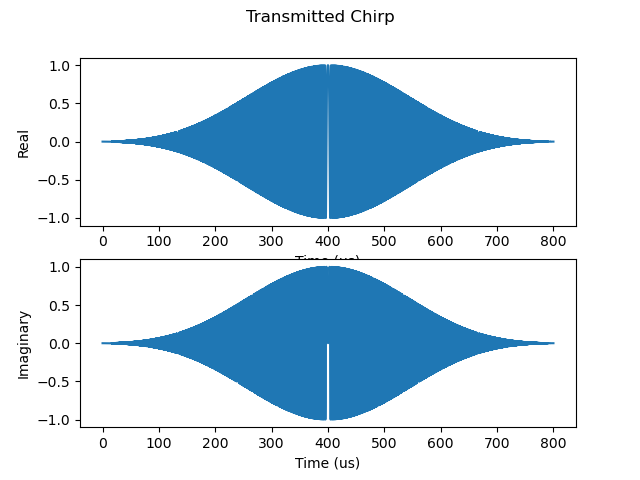

In [333]:
# Read and plot RX/TX
# This cell loads all of the data - it can take a while with a large file. You don't need to re-run this cell if you only change n_stack
_, tx_sig = generate_chirp(config)
pr.plotChirpVsTime(tx_sig, 'Transmitted Chirp', sample_rate)
print(f"len(tx_sig): {len(tx_sig)}")

t0 = datetime.datetime.now()
rx_sig = pr.extractSig(rx_samps)
print(datetime.datetime.now() - t0)

(-200.0, 0.0)

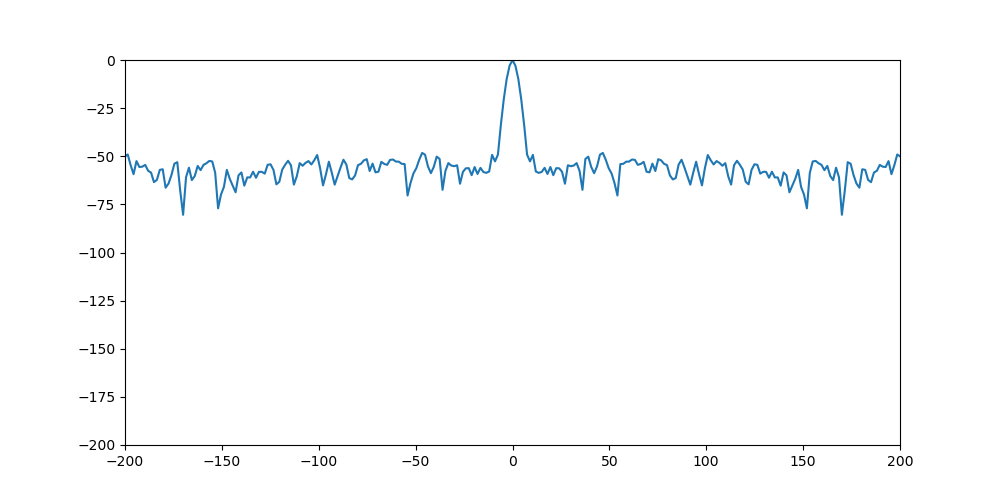

In [347]:
chirp_scaling = np.cumsum(np.random.randn(len(tx_sig)))
chirp_scaling = butter_lowpass_filter(chirp_scaling, 0.001, 1)
chirp_scaling = chirp_scaling - np.min(chirp_scaling)
chirp_scaling = chirp_scaling / np.max(chirp_scaling)

tx_sig_autocorr = sp.correlate(tx_sig, tx_sig * chirp_scaling, mode='same', method='auto')
rx_sig_autocorr = sp.correlate(rx_sig_reshaped[:len(tx_sig),0], rx_sig_reshaped[:len(tx_sig),0], mode='same', method='auto')

distance_to_reflector = np.linspace(0, len(tx_sig_autocorr)/sample_rate, len(tx_sig_autocorr)) * sig_speed / 2
distance_to_reflector = distance_to_reflector - distance_to_reflector[len(tx_sig_autocorr)//2]

fig, ax = plt.subplots(figsize=(10,5))
tx_sig_autocorr_db = 20*np.log10(np.abs(rx_sig_autocorr))
ax.plot(distance_to_reflector, tx_sig_autocorr_db - np.max(tx_sig_autocorr_db))

ax.set_xlim(-200,200)
#ax.set_xlim(len(tx_sig_autocorr)/2 - 200, len(tx_sig_autocorr)/2 + 200)
ax.set_ylim(-200,0)

In [337]:
n_rxs = len(rx_sig) // rx_len_samples
rx_sig_reshaped = np.transpose(np.reshape(rx_sig, (n_rxs, rx_len_samples), order='C'))

print(f"len(rx_sig): {len(rx_sig)}")
print(f"n_rxs: {n_rxs}")
print(f"rx_sig shape: {np.shape(rx_sig)}")
print(f"rx_sig_reshaped shape: {np.shape(rx_sig_reshaped)}")

len(rx_sig): 5923680
n_rxs: 129
rx_sig shape: (5923680,)
rx_sig_reshaped shape: (45920, 129)


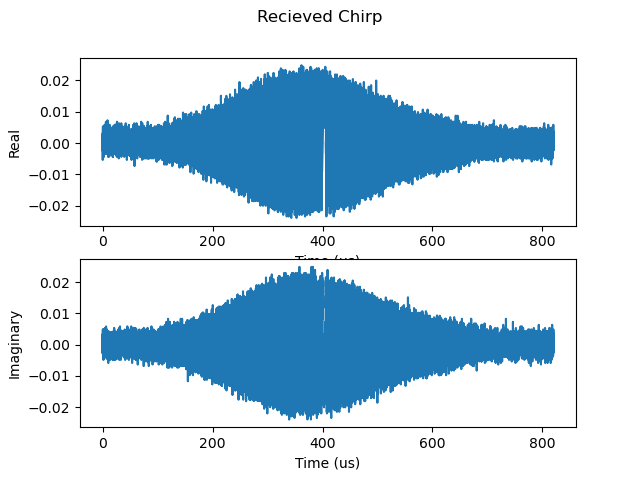

In [338]:
pr.plotChirpVsTime(rx_sig_reshaped[:,0], 'Recieved Chirp', sample_rate)
plt.savefig(prefix + "_rx_chirp.png")

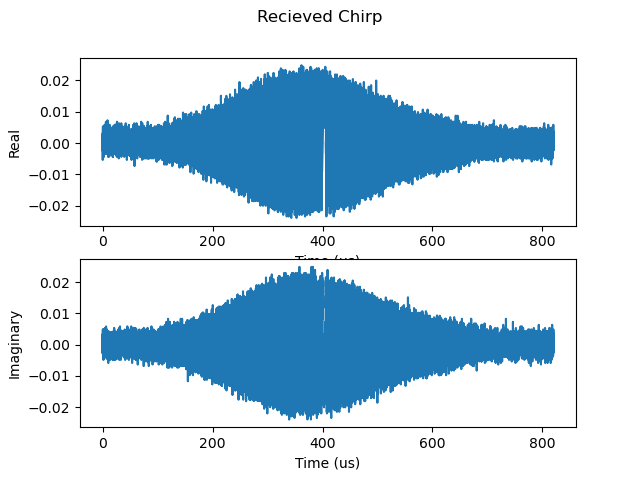

In [339]:
pr.plotChirpVsTime(rx_sig_reshaped[:,0], 'Recieved Chirp', sample_rate)

interactive(children=(IntSlider(value=15, description='n_stack', max=50, min=1), IntSlider(value=0, descriptio…

<function __main__.plot_radargram(n_stack, start_time_s=0, duration_s=50)>

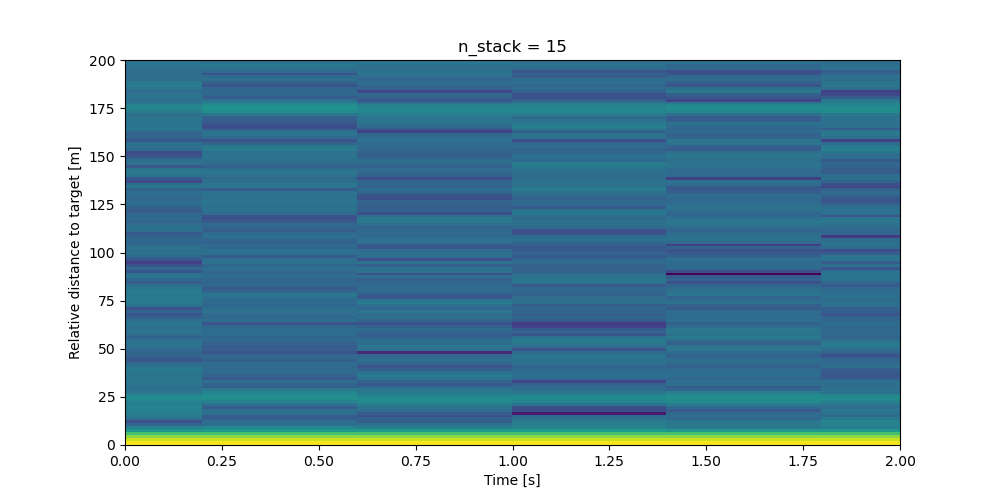

In [340]:
def plot_radargram(n_stack, start_time_s=0, duration_s=50): #start_time_s=150, duration_s=250):
    
    overlay_distance_on_radargram = True
    
    slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(rx_sig_reshaped)[1])
    
    start_idx = np.argmin(np.abs(slow_time - start_time_s))
    end_idx = np.argmin(np.abs(slow_time - (start_time_s + duration_s)))
    actual_duration_s = slow_time[end_idx] - slow_time[start_idx]
    
    rx_sig_cropped = rx_sig_reshaped[:, start_idx:end_idx]
    
    # Coherent stacking
    xcorr_results = np.zeros(((rx_len_samples-len(tx_sig))+1, np.shape(rx_sig_cropped)[1]//n_stack), dtype=np.csingle)
    #print(f"shape of xcorr_results: {np.shape(xcorr_results)}")

    for res_idx in range(np.shape(xcorr_results)[1]):
        stacked = np.mean(rx_sig_cropped[:,res_idx*n_stack:(res_idx+1)*n_stack], axis=1)
        xcorr_results[:, res_idx] = sp.correlate(stacked, tx_sig, mode='valid', method='auto')

        
    fig, axs = plt.subplots(1,1, figsize=(10,5), facecolor='white', sharex=True)
    axs = [axs]
    
    slow_time = np.linspace(start_time_s, start_time_s+actual_duration_s, np.shape(xcorr_results)[1])
    distance_to_reflector = np.linspace(0, np.shape(xcorr_results)[0]/sample_rate, np.shape(xcorr_results)[0]) * sig_speed / 2
    distance_to_reflector = distance_to_reflector - distance_to_reflector[zero_sample_idx]

    p = axs[0].pcolormesh(slow_time, distance_to_reflector, 20*np.log10(np.abs(xcorr_results)), shading='auto')
    #clb = fig.colorbar(p, ax=axs[0])
    #clb.set_label('Power [dB]')
    axs[0].set_xlabel('Time [s]')
    axs[0].set_ylabel('Relative distance to target [m]')
    
    # Plot PX4 log data
    
    if px4_logs is not None:
        df = pd.read_csv(px4_logs + "distance_sensor_0.csv")
        axs[1].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['current_distance'], label='Laser Rangefinder')
        if overlay_distance_on_radargram:
            axs[0].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['current_distance'], label='Laser Rangefinder', linestyle=(0, (5,10)))
        df = pd.read_csv(px4_logs + "estimator_global_position_0.csv")
        axs[1].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['alt']-np.min(df['alt']), label='Fused estimate')
        if overlay_distance_on_radargram:
            axs[0].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['alt']-np.min(df['alt']), label='Fused estimate', linestyle=(0, (5,10)))
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Altitude above ground [m]')
        axs[1].legend()
        axs[1].grid()
        
        # YPR
        df = pd.read_csv(px4_logs + "estimator_attitude_0.csv")
        qx, qy, qz, qw = df['q[0]'], df['q[1]'], df['q[2]'], df['q[3]']

        yaw = np.arctan2(2.0*(qy*qz + qw*qx), qw*qw - qx*qx - qy*qy + qz*qz)
        pitch = -1*np.arcsin(-2.0*(qx*qz - qw*qy))
        roll = np.arctan2(2.0*(qx*qy + qw*qz), qw*qw + qx*qx - qy*qy - qz*qz)

        #axs[2].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, yaw*(180/np.pi), label='Yaw')
        axs[2].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, pitch*(180/np.pi), label='Pitch')
        axs[2].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, roll*(180/np.pi), label='Roll')
        axs[2].set_ylabel('Estimated Angle [deg]')
        #axs[2].legend()
        axs[2].grid()
        
        # Throttle
        ax_throttle = axs[2].twinx()
        df = pd.read_csv(px4_logs + "actuator_controls_0_0.csv")
        ax_throttle.plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['control[3]'], label='Throttle', color='red')
        axs[2].legend()
        
    
    axs[0].set_ylim(0,200)
    #axs[1].set_ylim(0,100)
    axs[0].set_title(f"n_stack = {n_stack}")
    axs[0].set_xlim(start_time_s,start_time_s+duration_s)
    
#     df = pd.read_csv(px4_logs + "actuator_controls_0_0.csv")
#     axs[1].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-34, df['control[3]'])

    fig.show()
    return fig, axs

widgets.interact(plot_radargram, n_stack=widgets.IntSlider(min=1, max=50, step=1, value=15), duration_s=widgets.IntSlider(min=1, max=900, step=1, value=2), start_time_s=widgets.IntSlider(min=0, max=800, value=0))

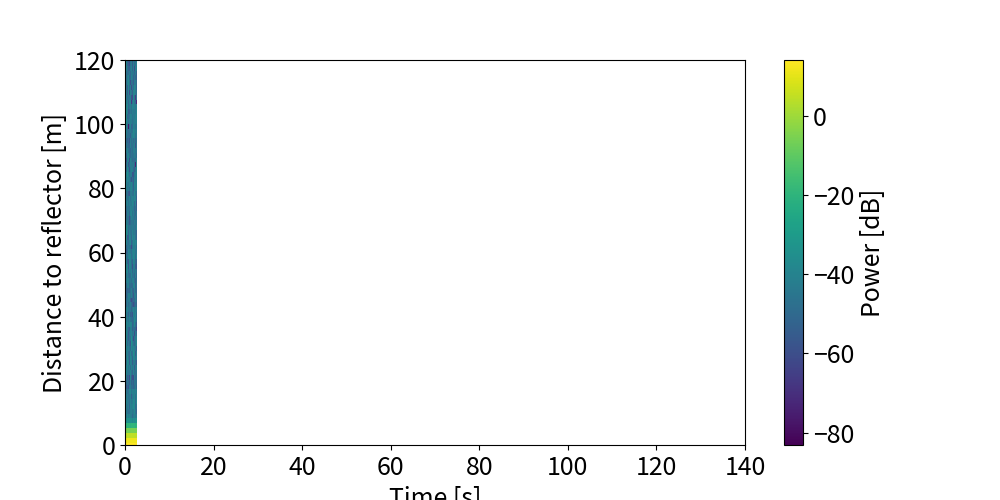

In [341]:
## Figure version

n_stack = 10
start_time_s = 0
duration_s = 140#802
use_recorded_chirp = True
    
slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(rx_sig_reshaped)[1])

start_idx = np.argmin(np.abs(slow_time - start_time_s))
end_idx = np.argmin(np.abs(slow_time - (start_time_s + duration_s)))
actual_duration_s = slow_time[end_idx] - slow_time[start_idx]

rx_sig_cropped = rx_sig_reshaped[:, start_idx:end_idx]

# Coherent stacking
xcorr_results = np.zeros(((rx_len_samples-len(tx_sig))+1, np.shape(rx_sig_cropped)[1]//n_stack), dtype=np.csingle)
#print(f"shape of xcorr_results: {np.shape(xcorr_results)}")

for res_idx in range(np.shape(xcorr_results)[1]):
    stacked = np.mean(rx_sig_cropped[:,res_idx*n_stack:(res_idx+1)*n_stack], axis=1)
    if use_recorded_chirp:
        xcorr_results[:, res_idx] = sp.correlate(stacked, rx_sig_reshaped[:len(tx_sig),res_idx*n_stack], mode='valid', method='auto')
    else:
        xcorr_results[:, res_idx] = sp.correlate(stacked, tx_sig, mode='valid', method='auto')
    

        
fig, ax = plt.subplots(1,1, figsize=(10,5), facecolor='white', sharex=True)
axs = [ax]

slow_time = np.linspace(start_time_s, start_time_s+actual_duration_s, np.shape(xcorr_results)[1])
distance_to_reflector = np.linspace(0, np.shape(xcorr_results)[0]/sample_rate, np.shape(xcorr_results)[0]) * sig_speed / 2
if not use_recorded_chirp:
    distance_to_reflector = distance_to_reflector - distance_to_reflector[zero_sample_idx]

p = axs[0].pcolormesh(slow_time, distance_to_reflector, 20*np.log10(np.abs(xcorr_results)), shading='auto')
clb = fig.colorbar(p, ax=axs[0])
clb.set_label('Power [dB]')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Distance to reflector [m]')

# Plot PX4 log data

if px4_logs is not None:
    #df = pd.read_csv(px4_logs + "distance_sensor_0.csv")
    #axs[0].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['current_distance'], label='Laser Rangefinder', linestyle=(0, (5,10)))
    df = pd.read_csv(px4_logs + "estimator_global_position_0.csv")
    axs[0].plot(((df['timestamp']-np.min(df['timestamp']))*1e-6)-telemetry_time_offset_s, df['alt']-np.min(df['alt']), label='UAV Altitude',
                linestyle=(0, (5,10)), color='black', alpha=0.3)
    axs[0].legend()


axs[0].set_ylim(0,120)
#axs[0].set_title(f"n_stack = {n_stack}")
axs[0].set_xlim(start_time_s,start_time_s+duration_s)


for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, clb.ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + clb.ax.get_yticklabels()): #ax.get_legend().get_texts()
    item.set_fontsize(20)
    item.set_fontfamily('sans-serif')
    item.set_fontname('Source Sans Pro')
    
#fig.savefig('radargram.png', dpi=300)

In [342]:
print(f"Peak: {np.max(20*np.log10(np.abs(xcorr_results))):.2f} dB, Median: {np.median(20*np.log10(np.abs(xcorr_results))):.2f} dB")

Peak: 14.26 dB, Median: -44.91 dB


In [343]:
rx_sig_reshaped[:,0].shape

(45920,)

In [344]:
tx_sig.shape

(44800,)

interactive(children=(IntSlider(value=0, description='start_chirp_idx', max=128), IntSlider(value=1, descripti…

<function __main__.plot_timestep(start_chirp_idx, n_stack, use_recorded_chirp=False)>

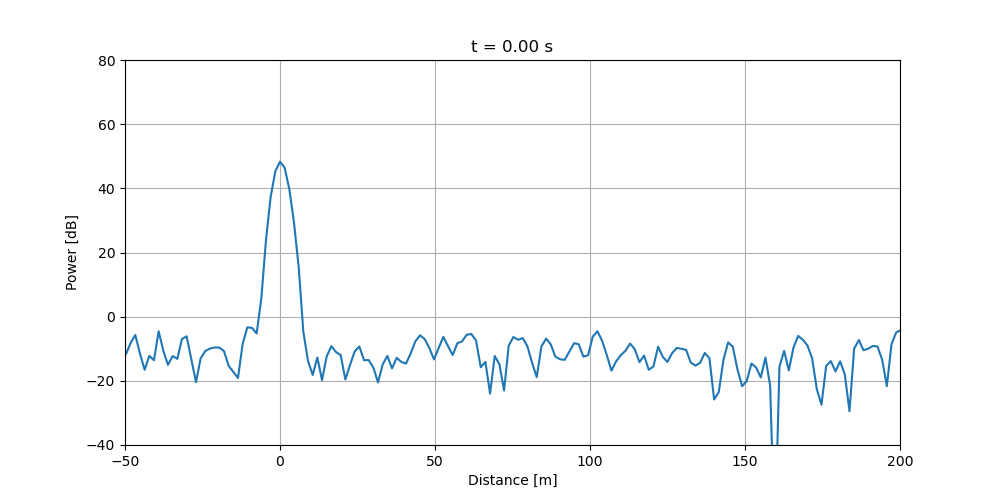

In [346]:
# Must enable widgets (see imports block) for this to work

def plot_timestep(start_chirp_idx, n_stack, use_recorded_chirp=False):
    
    stacked = np.mean(rx_sig_reshaped[:,start_chirp_idx:start_chirp_idx+n_stack], axis=1)
    
    if use_recorded_chirp:
        xcorr_res_tmp = sp.correlate(stacked, rx_sig_reshaped[:len(tx_sig),start_chirp_idx], mode='valid', method='direct')
    else:
        xcorr_res_tmp = sp.correlate(stacked, tx_sig, mode='valid', method='direct')
    
    
    slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(rx_sig_reshaped)[1])
    
    distance_to_reflector = np.linspace(0, np.shape(xcorr_res_tmp)[0]/sample_rate, np.shape(xcorr_res_tmp)[0]) * sig_speed / 2
    if not use_recorded_chirp:
        distance_to_reflector = distance_to_reflector - distance_to_reflector[zero_sample_idx]
    
    fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
    line = ax.plot(distance_to_reflector, 20*np.log10(np.abs(xcorr_res_tmp)))
    mplcursors.cursor(line)
    ax.set_ylim(0,100)
    ax.set_ylim(-40,80)
    #ax.set_ylim(20,100)
    #ax.set_xlim(-80, 180)
    ax.set_xlim(-50,200)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Power [dB]')
    ax.set_title(f't = {slow_time[start_chirp_idx]:.2f} s')
    ax.grid()
    
    fig.show()
    
    return fig, ax
    
widgets.interact(plot_timestep,
                 start_chirp_idx=widgets.IntSlider(min=0, max=np.shape(rx_sig_reshaped)[1]-1, step=1, value=0),
                 n_stack=widgets.IntSlider(min=1, max=1000, step=1, value=0))

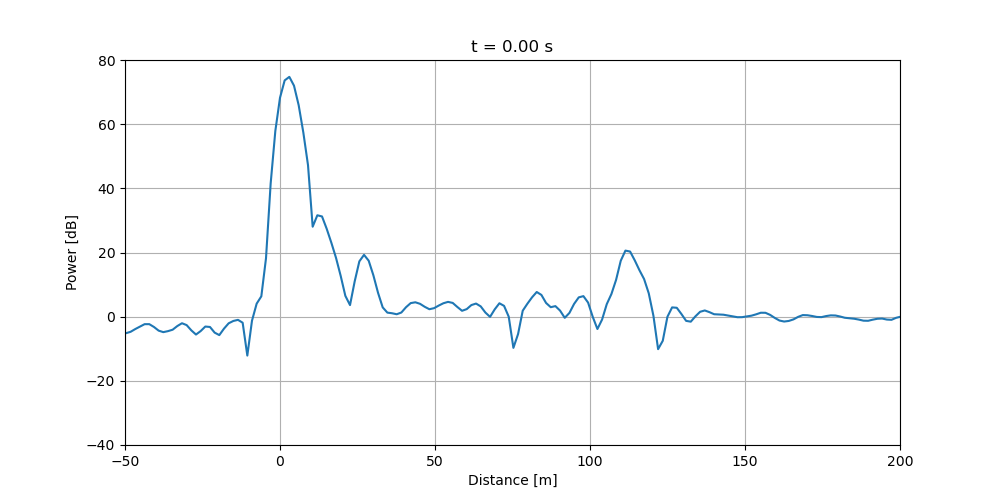

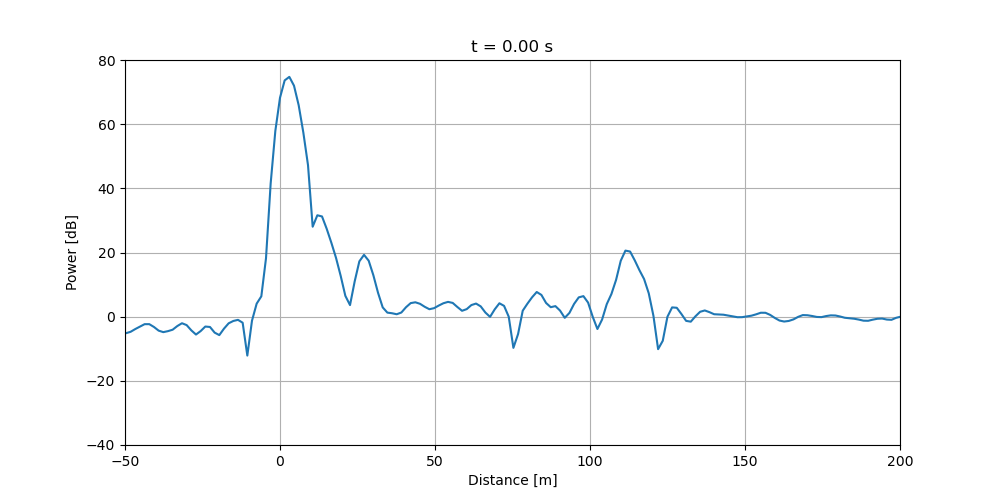

In [180]:
fig, ax = plot_timestep(0, 500)
fig.savefig(prefix + "_stacked500_timestep0.png")

In [ ]:
def plot_single_rx_chirp(chirp_idx):
    slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(rx_sig_reshaped)[1])
    
    fig, axs = plt.subplots(1,2, figsize=(14,4), facecolor='white')
    axs[0].plot(np.real(rx_sig_reshaped[:, chirp_idx]))
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Digitized value')
    axs[0].set_title(f't = {slow_time[chirp_idx]:.2f} s')
    #axs[0].set_ylim(0.75,1.1)

    f, t, Sxx = sp.spectrogram(rx_sig_reshaped[:, chirp_idx], sample_rate, return_onesided=False)
    axs[1].pcolormesh(t, scipy.fft.fftshift(f)/1e6, scipy.fft.fftshift(Sxx, axes=0), shading='gouraud')
    axs[1].set_ylabel('Frequency [MHz]')
    axs[1].set_xlabel('Time [sec]')
    
    return fig, ax

widgets.interact(plot_single_rx_chirp,
                 chirp_idx=widgets.IntSlider(min=0, max=np.shape(rx_sig_reshaped)[1]-1, step=1, value=0))

In [ ]:
def plot_single_rx_chirp(chirp_idx):
    slow_time = np.linspace(0, config['CHIRP']['pulse_rep_int']*config['CHIRP']['num_presums']*n_rxs, np.shape(rx_sig_reshaped)[1])
    
    fig, axs = plt.subplots(1,2, figsize=(14,4), facecolor='white')
    axs[0].plot(np.real(rx_sig_reshaped[:, chirp_idx]))
    axs[0].set_xlabel('Sample')
    axs[0].set_ylabel('Digitized value')
    axs[0].set_title(f't = {slow_time[chirp_idx]:.2f} s')
    axs[0].set_xlim(0,1000)
    #axs[0].set_ylim(0.75,1.1)

    f, t, Sxx = sp.spectrogram(rx_sig_reshaped[:, chirp_idx], sample_rate, return_onesided=False)
    axs[1].pcolormesh(t, scipy.fft.fftshift(f)/1e6, scipy.fft.fftshift(Sxx, axes=0), shading='gouraud')
    axs[1].set_ylabel('Frequency [MHz]')
    axs[1].set_xlabel('Time [sec]')
    
    return fig, ax

widgets.interact(plot_single_rx_chirp,
                 chirp_idx=widgets.IntSlider(min=0, max=np.shape(rx_sig_reshaped)[1]-1, step=1, value=0))